In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
 # Loading the wind dataset
df = pd.read_csv("C:/users/FurkanBulut/Desktop/T1totalclean.csv", index_col="timestamp", parse_dates=True)
df.head()
#Calculate Wind Speed cube for each row and create a new column named "WindSpeedCube"
df['WindSpeedCube'] = df['windspeed']**3

#Make last column to power 
df = df[["windspeed","winddirection","PitchAngle","temperature","WindSpeedCube","power"]]

df.head()
#Nan value yerine mean degeri koy
df = df.fillna(df.mean())   

#Power can not be negative, so make all negative values to zero
df.loc[df['power'] < 0, 'power'] = 0

df.describe

#Function to create x,y components of wind speed
#function to create x,y component of wind direction 
def x_y_component(wind_direction, wind_speed):
    """Convert degrees to x,y components"""
#convert to radians     
    radians = (wind_direction * np.pi)/180
# give the x, y compenents     
    x = wind_speed * np.cos(radians)
    y = wind_speed * np.sin(radians)
    return x,y
# create two extra columns in raw_data_nm for x,y compnenents of wind direction df['x_com'], df['y_com'] = x_y_component(df['WindDirection'],                                                           df['WindSpeed'])
df.head()

# create two extra columns in raw_data_nm for x,y compnenents of wind direction 
df['x_com'], df['y_com'] = x_y_component(df['winddirection'],df['windspeed'])
df.head()
df["Hour"] = df.index.hour
df["DayOfWeek"] = df.index.dayofweek
df["Month"] = df.index.month
df.head ()
# Create rolling mean and standard deviation features for wind speed, temperature, and power
df['WindSpeedRollingMean'] = df['windspeed'].rolling(window=24).mean()
df['PowerRollingMean'] = df['power'].rolling(window=24).mean()

df.head()

#Nan değerleri sıfır yap
df = df.fillna(0)
df.isnull().sum()

#df nin bütün verilerini nümerik hale getir
df = df.apply(pd.to_numeric)
df.head()
#Hout, DayOfWeek, Month kolonlarını float yap
df['Hour'] = df['Hour'].astype(float)
df['DayOfWeek'] = df['DayOfWeek'].astype(float)
df['Month'] = df['Month'].astype(float)
df.dtypes
#Day of week, hour, month kolonlarının sinüs ve kosinüs değerlerini al
df['DayOfWeekSin'] = np.sin(df.DayOfWeek*(2.*np.pi/7))
df['DayOfWeekCos'] = np.cos(df.DayOfWeek*(2.*np.pi/7))
df['HourSin'] = np.sin(df.Hour*(2.*np.pi/24))
df['HourCos'] = np.cos(df.Hour*(2.*np.pi/24))
df['MonthSin'] = np.sin((df.Month-1)*(2.*np.pi/12))
df['MonthCos'] = np.cos((df.Month-1)*(2.*np.pi/12))
df.head()
def create_lag(df: pd.core.frame.DataFrame, column: str, lags: list) -> pd.core.frame.DataFrame:
    """
    Function that allows to create lagged features.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
    
    column : str
        column to be transformed.
    
    lags : list
        Lag numbers.

    Returns
    -------
    pd.core.frame.DataFrame
        Lagged feature.

    """
    for lag in lags:
        df[column + "_lag_" + str(lag)] = df[column].shift(periods=lag).astype(np.float32)
    
    return df

df = create_lag(df=df, column="windspeed", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="winddirection", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="PitchAngle", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="power", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="x_com", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="y_com", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="temperature", lags=[1, 2, 3, 6])


df.head()

,windspeed,winddirection,PitchAngle,temperature,WindSpeedCube,power,x_com,y_com,Hour,DayOfWeek,...,x_com_lag_3,x_com_lag_6,y_com_lag_1,y_com_lag_2,y_com_lag_3,y_com_lag_6,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,140.608,180.899994,-4.390506,2.786299,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,157.464,213.300003,-4.050600,3.571084,0.0,1.0,...,NaN,NaN,2.786299,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,125.000,164.100006,-3.913041,3.112573,0.0,1.0,...,NaN,NaN,3.571084,2.786299,NaN,NaN,5.0,5.0,NaN,NaN
2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,42.875,21.799999,-2.341957,2.601007,0.0,1.0,...,-4.390505,NaN,3.112573,3.571084,2.786299,NaN,5.0,5.0,5.0,NaN
2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,54.872,48.299999,-2.774616,2.596441,0.0,1.0,...,-4.050600,NaN,2.601007,3.112573,3.571084,NaN,5.0,5.0,5.0,NaN


In [2]:
df.drop(['temperature_lag_1', 'temperature_lag_2','temperature_lag_3', 'temperature_lag_6','PitchAngle_lag_2', 'PitchAngle_lag_3','PitchAngle_lag_6','winddirection_lag_1','winddirection_lag_2','winddirection_lag_6'], axis=1, inplace=True)
df.head()

,windspeed,winddirection,PitchAngle,temperature,WindSpeedCube,power,x_com,y_com,Hour,DayOfWeek,...,power_lag_3,power_lag_6,x_com_lag_1,x_com_lag_2,x_com_lag_3,x_com_lag_6,y_com_lag_1,y_com_lag_2,y_com_lag_3,y_com_lag_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,140.608,180.899994,-4.390506,2.786299,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,157.464,213.300003,-4.050600,3.571084,0.0,1.0,...,NaN,NaN,-4.390505,NaN,NaN,NaN,2.786299,NaN,NaN,NaN
2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,125.000,164.100006,-3.913041,3.112573,0.0,1.0,...,NaN,NaN,-4.050600,-4.390505,NaN,NaN,3.571084,2.786299,NaN,NaN
2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,42.875,21.799999,-2.341957,2.601007,0.0,1.0,...,180.899994,NaN,-3.913041,-4.050600,-4.390505,NaN,3.112573,3.571084,2.786299,NaN
2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,54.872,48.299999,-2.774616,2.596441,0.0,1.0,...,213.300003,NaN,-2.341957,-3.913041,-4.050600,NaN,2.601007,3.112573,3.571084,NaN


In [3]:
#fill nan values with 0
df = df.fillna(0)
df.isnull().sum()

windspeed               0
winddirection           0
PitchAngle              0
temperature             0
WindSpeedCube           0
power                   0
x_com                   0
y_com                   0
Hour                    0
DayOfWeek               0
Month                   0
WindSpeedRollingMean    0
PowerRollingMean        0
DayOfWeekSin            0
DayOfWeekCos            0
HourSin                 0
HourCos                 0
MonthSin                0
MonthCos                0
windspeed_lag_1         0
windspeed_lag_2         0
windspeed_lag_3         0
windspeed_lag_6         0
winddirection_lag_3     0
PitchAngle_lag_1        0
power_lag_1             0
power_lag_2             0
power_lag_3             0
power_lag_6             0
x_com_lag_1             0
x_com_lag_2             0
x_com_lag_3             0
x_com_lag_6             0
y_com_lag_1             0
y_com_lag_2             0
y_com_lag_3             0
y_com_lag_6             0
dtype: int64

In [4]:
multivar_df = df.copy()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 

def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [6]:


def split_data(series, train_fraq, test_len=25000):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last %10 of data for testing has point 
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data


multivar_df = clean_data(multivar_df)

#scale
multivar_df = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.7, test_len=19282)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape: (110644, 37)
Val Data Shape: (47419, 37)
Test Data Shape: (19282, 37)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


In [7]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

tf.random.set_seed(42)

n_steps = 720
n_horizon = 6
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Example sample shapes
x =  (1, 720, 37)
y =  (1, 6, 1)


In [8]:
def build_dataset(train_fraq=0.7, 
                  n_steps=24*6*5, 
                  n_horizon=6, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = multivar_df
    
    else:
        data = multivar_df['power']
        

    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [9]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*6*5
    n_horizon=6
    
    if multivar:
        n_features=37
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [10]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae', "mse"])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 26640)             0         
                                                                 
 dense (Dense)               (None, 128)               3410048   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,427,334
Trainable params: 3,427,334
Non-trainab

c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
tf.keras.utils.plot_model(dnn, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae', "mse"])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           14272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

In [13]:
tf.keras.utils.plot_model(cnn, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae', "mse"])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           31680     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774    

In [15]:
tf.keras.utils.plot_model(lstm, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae', "mse"])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           14272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [17]:
tf.keras.utils.plot_model(lstm_cnn, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae', "mse"])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 37)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      14272       ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

In [19]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=1)
run_model("cnn", cnn_model, model_configs, epochs=1)
run_model("lstm", lstm_model, model_configs, epochs=0)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=0)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=0)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


77/77 [==============================] - 33s 407ms/step - loss: 0.2812 - mae: 0.5052 - mse: 2.1434 - val_loss: 0.0187 - val_mae: 0.1665 - val_mse: 0.0374
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


77/77 [==============================] - 42s 526ms/step - loss: 0.1789 - mae: 0.3260 - mse: 1.1323 - val_loss: 0.0064 - val_mae: 0.0905 - val_mse: 0.0128
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 6
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


c:\Users\FurkanBulut\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [21]:
#save dnn model
dnn.save("C:/Users/FurkanBulut/Desktop/test/T1dnn.h5")
#save cnn model
cnn.save("C:/Users/FurkanBulut/Desktop/test/T1cnn.h5")
#save lstm model
lstm.save("C:/Users/FurkanBulut/Desktop/test/T1lstm.h5")
#save lstm_cnn model
lstm_cnn.save("C:/Users/FurkanBulut/Desktop/test/T1lstm_cnn.h5")
#save lstm_skip model
lstm_skip.save("C:/Users/FurkanBulut/Desktop/test/T1lstm_skip.h5")


KeyError: 'loss'

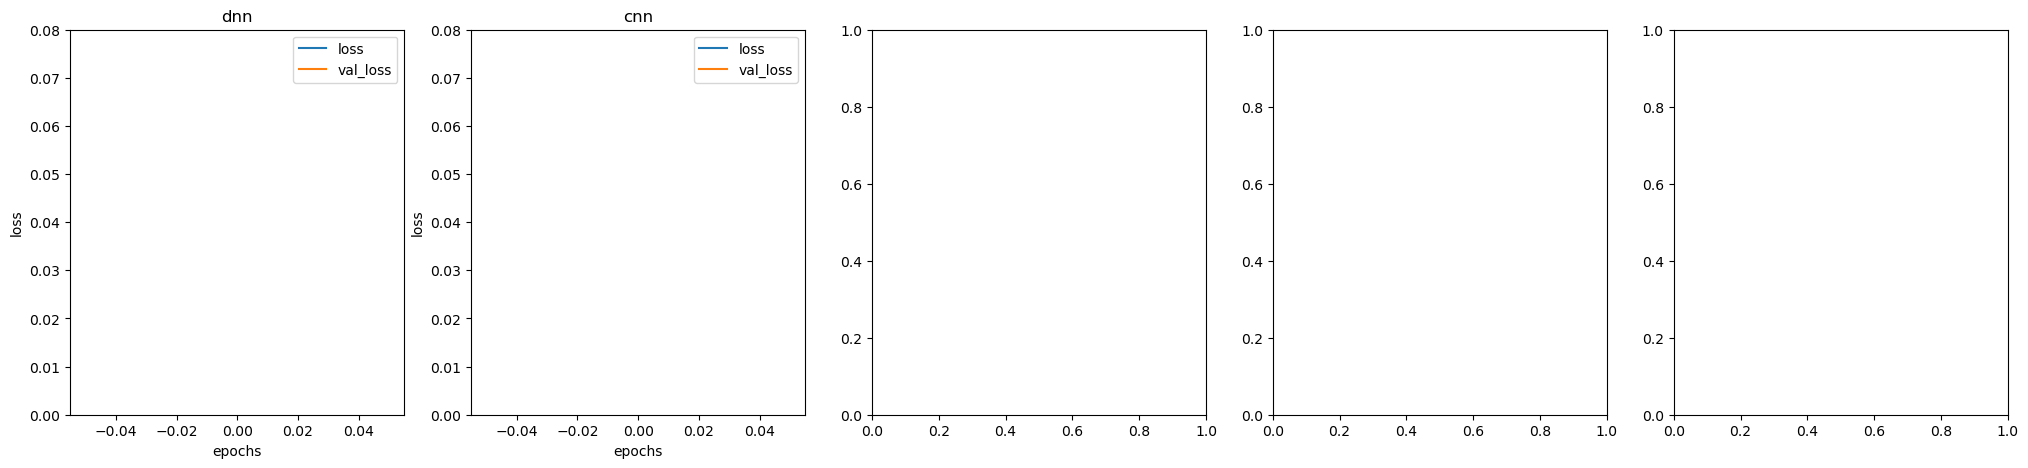

In [22]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs("loss", val, ax, 0.08)
print("Loss Curves")

In [ ]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.3)

In [ ]:
#rmse for each model
for key, val in model_configs.items():
    print(f"{key} RMSE: {val['model'].evaluate(val['test_ds'])[1]}")



In [ ]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['power'].mean()
print(performance_df)    

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(30, 20))
days = 6

vline = np.linspace(0, days,)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)
    xbatch, ybatch = iter(test).get_next()
    ybatch = ybatch.numpy()[:days]
    print(ybatch)
    ax.plot(ybatch.reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Minutes Cumulative")
print('Predictions')

In [ ]:
#draw actual and predicted values
fig, axs = plt.subplots(5, 1, figsize=(30, 20))
days = 7

vline = np.linspace(0, days, days+1)

for (key, val), ax in zip(model_configs.items(), axs):
    
        test = val['test_ds']
        preds = val['model'].predict(test)
    
        xbatch, ybatch = iter(test).get_next()
    
        ax.plot(ybatch.numpy()[:days].reshape(-1))
        ax.plot(preds[:days].reshape(-1))
        ax.set_title(key)
        ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
        ax.legend(["Actual", "Predicted"])

plt.xlabel("Minutes Cumulative")
print('Predictions')

